[*********************100%***********************]  1 of 1 completed

Index(['Volume', 'MACD_HIST', 'Target'], dtype='object', name='Price')
Optimization terminated successfully.
         Current function value: 0.693008
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:                 5081
Model:                          Logit   Df Residuals:                     5078
Method:                           MLE   Df Model:                            2
Date:                Tue, 16 Dec 2025   Pseudo R-squ.:               3.448e-05
Time:                        20:47:06   Log-Likelihood:                -3521.2
converged:                       True   LL-Null:                       -3521.3
Covariance Type:            nonrobust   LLR p-value:                    0.8857
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0298      0.033     

Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_HIST,Close + 1,Target,Prediction
0,309.009399,309.500000,304.339996,307.250000,320483,309.009399,309.009399,0.000000,0.000000,0.000000,310.450012,1,0
1,310.450012,310.600006,307.760010,309.010010,147002,309.789731,309.756384,0.033348,0.018526,0.014821,311.000000,1,0
2,311.000000,311.000000,308.929993,310.600006,127632,310.262099,310.201994,0.060105,0.035567,0.024538,310.839996,0,0
3,310.839996,311.644989,310.019989,311.000000,247682,310.444519,310.379638,0.064881,0.045497,0.019384,313.589996,1,0
4,313.589996,313.599304,310.679993,310.799988,146479,311.299134,311.120215,0.178919,0.085187,0.093731,313.119995,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5076,204.115005,207.600006,203.750000,205.220001,459040,203.756418,198.913852,4.842566,5.141418,-0.298852,204.220001,1,0
5077,204.220001,204.759094,203.270096,204.115005,324003,203.827738,199.292863,4.534876,5.020110,-0.485234,204.645004,1,0
5078,204.645004,205.199997,204.085800,204.235001,241024,203.953472,199.675158,4.278313,4.871750,-0.593437,204.960007,1,0
5079,204.960007,205.800003,204.188004,204.960007,263350,204.108323,200.052648,4.055676,4.708535,-0.652860,205.574997,1,0


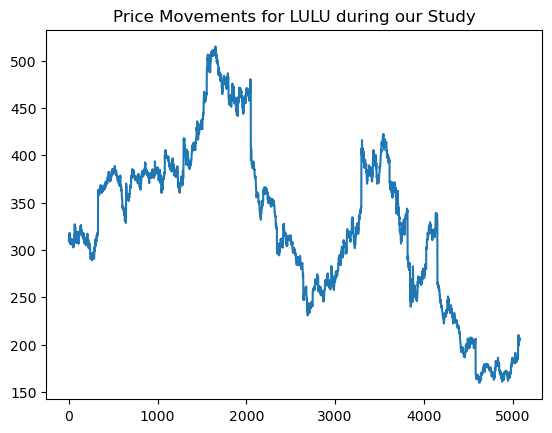

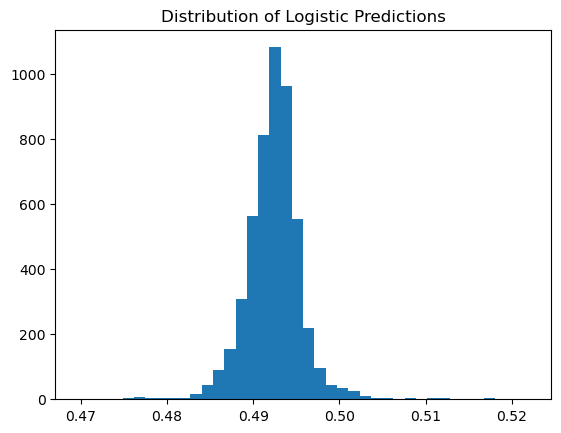

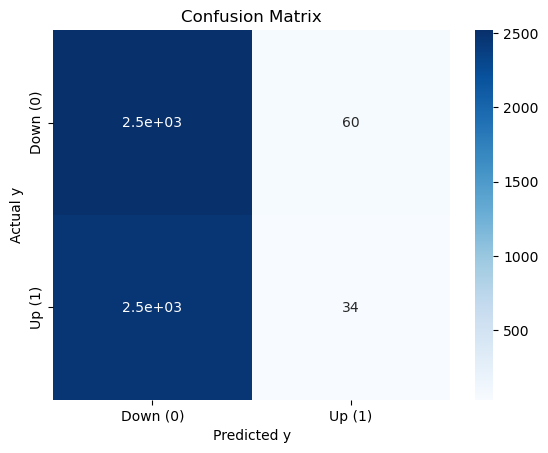

In [21]:
import numpy as np 
import pandas as pd
from pandas.plotting import lag_plot
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import confusion_matrix # pip install scikit-learn
from curl_cffi import requests # pip install curl_cffi

TICKER = "LULU"

INTERVAL = "1h"
if INTERVAL == "1h":
    PERIOD = "730d"
else: 
    PERIOD = "max"

SHIFT = 1 
LOOKBACK = 10000

STRATEGY = ["Volume", "MACD_HIST"]

MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

SESSION = requests.Session(impersonate="chrome")

def get_data(ticker = TICKER, session = SESSION, interval = INTERVAL, lookback = LOOKBACK):

    df = yf.download(ticker, session = session, interval = interval, period = PERIOD)
    df.columns = df.columns.get_level_values(0)
    df = df.reset_index(drop=True)

    plt.figure()
    plt.plot(df["Close"])
    plt.title(f"Price Movements for {ticker} during our Study")

    return df.iloc[-lookback:, :]

# Add Features
def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):

    df[f"{fast}_ema"] = df["Close"].ewm(span = fast).mean()
    df[f"{slow}_ema"] = df["Close"].ewm(span = slow).mean()

    df["MACD"] = df[f"{fast}_ema"] - df[f"{slow}_ema"]

    df["Signal"] = df[f"MACD"].ewm(span = span).mean()

    df["MACD_HIST"] = df[f"MACD"] - df["Signal"]

    return df

# Add Target 
def add_target(df, shift = SHIFT):

    df[f"Close + {shift}"] = df["Close"].shift(-shift)
    df["Target"] = (df[f"Close + {shift}"] > df["Close"]) * 1

    return df

# --- (5) Generate Regression Output ---
def generate_regression_output(df, features=STRATEGY, target="Target"):

    subset = df[features + [target]].dropna()
    print(subset.columns)
    X = subset[features] 
    y = subset[target] 
    X_with_const = sm.add_constant(X)
    
    model = sm.Logit(y, X_with_const).fit()

    # We need the predicted Values of y. 
    y_pred_prob = model.predict(X_with_const)
    plt.figure()
    plt.hist(y_pred_prob, bins = 40)
    plt.title("Distribution of Logistic Predictions")
    ## Everything left to 0.5 will be a 0 and everything right to 0.5 will be a 1
    # A perefct distribution would be ceneterd around 0.5, but that is rare, because most datasets are skewed

    y_pred = (y_pred_prob > .5).astype(int) # List of responses that are either 0 or 1
    
    # Console Summary
    print(model.summary())
    df["Prediction"] = y_pred

    return df


def add_confusion_matrix(df):

    cm = confusion_matrix(df["Target"], df["Prediction"])
    labels = ["Down (0)", "Up (1)"]

    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure()

    sns.heatmap(cm_df, annot = True, cmap = "Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted y")
    plt.ylabel("Actual y")

    ## Understanding this Confusion Matrix

    return df

def main():

    df = get_data()
    df = add_MACD(df)
    df = add_target(df)
    df = generate_regression_output(df)
    df = add_confusion_matrix(df)

    return df 

df = main()
df


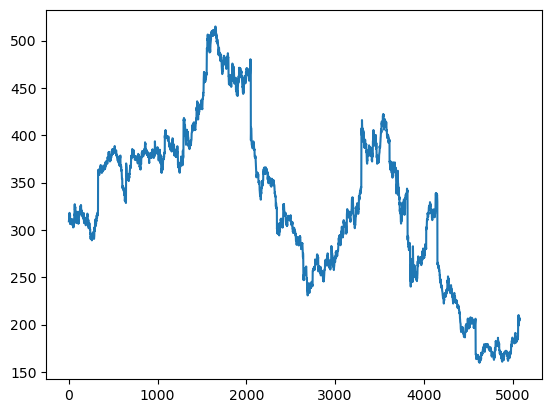

In [22]:
# Lets examine the Environment of our Study
plt.plot(df["Close"])
# As we can see, more often than not, the prices go up more than they go down 

In [23]:
df["Prediction"].value_counts()
# Down Days are rare, but they do stillm exist

Prediction
0    4987
1      94
Name: count, dtype: int64